# Vulcain Combustion Chamber

This notebook attempts to use Bamboo to recreate experimental and simulation data produced for the Ariane 5's Vulcain engine by Messerschmitt-Bölkow-Blohm (MBB).

Key points on the Vulcain engine:
- The combustion chamber is cooled seperately to the nozzle extension
- The nozzle extension is cooled by dump cooling
- The combustion chamber is regeneratively cooled
- The LH2 coolant is above the critical pressure, and so does not form bubbles or 'boil off' in the traditional sense.

We will only attempt to model the regeneratively cooled combustion chamber.

### Conclusions:
- Bamboo shows decent overall agreement with the Deutsche Aerospace simulation data (see end of notebook for results)
- Bamboo accurately predicts the exit coolant temperature (see end of notebook for results).
- Bamboo has a sharper peak in heat transfer rate than the Deutsche Aerospace data. This may be due due to Bamboo neglecting any axial heat transfer (which would smooth out the peak).
- It's important to use the throat conditions in pypropep to get the perfect gas gamma, otherwise the perfect gas model deviates significantly from equilibrium (e.g. CEA or ProPEP) and real life values.

### References:

- [1] - Kirner et al 1993, Development Status of the Vulcain Thrust Chamber (http://ftp.demec.ufpr.br/CFD/bibliografia/propulsao/kirner_et_al_1993.pdf)
- [2] - Pizzarelli et al 2013, Trade-off analysis of high-aspect-ratio-cooling-channels for rocket engines (https://www.sciencedirect.com/science/article/pii/S0142727X13001586)
- [3] - LeBail et al 1993, Numerical analysis of high aspect ratio cooling passage flow and heat transfer (https://arc.aiaa.org/doi/pdf/10.2514/6.1993-1829)

In [1]:
import bamboo as bam
import pypropep as ppp
from CoolProp.CoolProp import PropsSI
import cantera as ct
import matplotlib.pyplot as plt
import numpy as np

#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 130

### Collect Vulcain data

Using a an online graph image-to-data converter (http://www.graphreader.com/), we can obtain the raw data from Deutsche Aerospace.

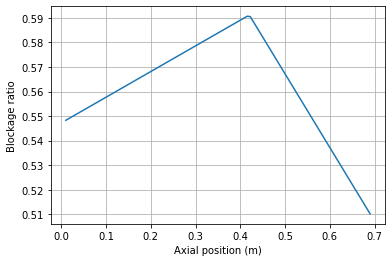

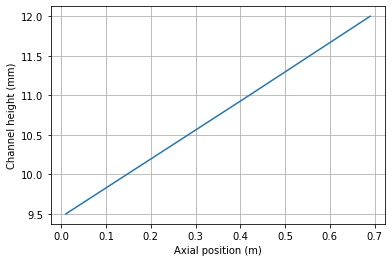

In [2]:
# Coolant temperature in K [1]
coolant_temperature_data = {"x":[0.00128, 0.04343, 0.10803, 0.21204, 0.27883, 0.36095, 0.44745, 0.51533, 0.59416, 0.63686, 0.68558],
                            "y":[96.883,93.279,87.802,78.865,73.099,64.162,55.802,48.883,42.396,38.793,35.045]}

# Heat flux in W/cm^2 [1]
heat_flux_data = {"x":[0,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68],
                  "y":[3392.201,3475.771,3546.043,3615.201,3687.672,3750.87,3777.94,3770.553,3753.173,3733.547,3713.45,3694.597,3678.699,3667.447,3661.987,3662.784,3670.26,3684.835,3705.399,3726.831,3746.404,3771.594,3809.186,3857.225,3912.077,3970.107,4029.233,4095.268,4176.523,4281.072,4408.404,4547.257,4690.436,4840.756,5000.567,5167.592,5340.659,5527.388,5731.296,5874.496,5929.249,5952.304,5898.527,5798.601,5657.307,5152.925,4818.711,4490.73,4162.569,3860.988,3574.203,3266.901,2978.681,2748.285,2554.031,2382.503,2230.471,2095.176,1974.176,1865.628,1768.807,1683.075,1607.502,1541.046,1482.716,1431.949,1388.386,1351.674,1321.606]}

# Engine contour (m) - up to the beginning of the nozzle extension [1]
engine_contour = {"x":[0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,0.41,0.42,0.43,0.44,0.45,0.46,0.47,0.48,0.49,0.5,0.51,0.52,0.53,0.54,0.55,0.56,0.57,0.58,0.59,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69],
                  "y":[0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.209,0.208,0.207,0.206,0.204,0.202,0.2,0.198,0.196,0.193,0.191,0.188,0.185,0.183,0.18,0.177,0.175,0.172,0.169,0.166,0.164,0.161,0.158,0.156,0.153,0.15,0.146,0.143,0.139,0.134,0.13,0.127,0.126,0.128,0.133,0.138,0.145,0.151,0.158,0.164,0.171,0.178,0.185,0.191,0.198,0.205,0.212,0.218,0.225,0.232,0.238,0.245,0.252,0.258,0.265,0.271,0.277,0.282,0.287,0.292]}

x_start = engine_contour["x"][0]
x_throat = engine_contour["x"][np.argmin(engine_contour["y"])]
x_end = engine_contour["x"][-1]

y_start = engine_contour["y"][0]
y_throat = min(engine_contour["y"])
y_end = engine_contour["y"][-1]

# Cooling channel
coolant_inlet_p = 137.9e5    # Coolant inlet pressure [3]
mdot_coolant = 33.42         # Coolant mass flow rate [2]
k_wall = 295                 # Wall thermal conductivity [2]
wall_thickness = 1e-3        # Wall thickness between coolant and exhaust gas [2]
number_of_channels = 360     # Number of fins [1]

# Cooling channel height [3]
height_start = 9.5e-3
height_throat = 11e-3
height_end = 12e-3

def channel_height(x):
    return np.interp(x, [x_start, x_throat, x_end], [height_start, height_throat, height_end])

# Fraction of cooling channel flow area that is blocked by fins [3]
blockage_start = number_of_channels * 2.0e-3 / (2 * np.pi * y_start)
blockage_throat = number_of_channels * 1.3e-3 / (2 * np.pi * y_throat)
blockage_end = number_of_channels * 2.6e-3 / (2 * np.pi * y_end)

def blockage_ratio(x):
    return np.interp(x, [x_start, x_throat, x_end], [blockage_start, blockage_throat, blockage_end])

# Experimental data
experimental_T_in = 36.198      # K [1]
experimental_T_out = 98.613     # K [1]
experimental_qdot = {"x" : 0.48741, "y" : 4475.676}  # x position in m, heat transfer rate in W/cm^2 [1]

# Plot geometry
x_for_plot = np.linspace(x_start, x_end, 100)
plt.plot(x_for_plot, blockage_ratio(x_for_plot))
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Blockage ratio")
plt.show()

plt.plot(x_for_plot, channel_height(x_for_plot)*1e3)
plt.grid()
plt.xlabel("Axial position (m)")
plt.ylabel("Channel height (mm)")
plt.show()

### Get chamber conditions

Use pypropep. The Vulcain uses a liquid oxygen and liquid hydrogen fed system.

In [3]:
thrust = 1007.7e3   # Vacuum thrust, N [1]
isp = 439*9.81      # Specific impulse, m/s [1]
pc = 100e5          # Chamber pressure, bar [1]
OF_ratio = 5.6      # O/F ratio (seems to be by mass) [1]

expected_mdot = thrust / isp

# Use pypropep to get chamber temperature
ppp.init()
p_froz = ppp.FrozenPerformance()
lox = ppp.PROPELLANTS['OXYGEN (LIQUID)']
lh2 = ppp.PROPELLANTS['HYDROGEN (CRYOGENIC)']

# Add propellants by mass fractions
p_froz.add_propellants_by_mass([(lox, OF_ratio), (lh2, 1)])

# Adiabatic combustion using chamber pressure                      
p_froz.set_state(P = pc/1e5, Pe = 1)   

# Get results - use throat conditions for gamma and cp! Otherwise the perfect gas model deviates a lot from equilibrium calculations.
gamma = p_froz.properties[1].Isex   # pyrpopep uses 'Isex' for the ratio of specific heats. Index 1 means throat conditions
cp = 1000*p_froz.properties[1].Cp   # Cp is given in kJ/kg/K, we want J/kg/K
Tc = p_froz.properties[0].T         # Index 0 means chamber conditions

print(f"Chamber temperature = {Tc} K")

print("\nCombustion product composition:")
print(p_froz.composition["throat"])

Loaded 1921 thermo species
Loaded 1031 propellants
Chamber temperature = 3459.2606127242298 K

Combustion product composition:
[('H2O', 0.6493671319106238), ('H2', 0.2896925690851782), ('OH', 0.028980423622929952), ('H', 0.028801796474919292), ('O', 0.0016810512414820072), ('O2', 0.0014520541971763574), ('HO2', 1.7031381331243065e-05), ('H2O2', 7.94208687267654e-06), ('O3', 0.0)]


### Bamboo engine model

First set up the perfect gas model, the geometry, and combustion chamber conditions. Use this to get the mass flow rate of exhaust gas.

In [4]:
# Set up the chamber conditions and geometry
perfect_gas = bam.PerfectGas(gamma = gamma, cp = cp)   
chamber_conditions = bam.ChamberConditions(p0 = pc, T0 = Tc)
geometry = bam.Geometry(xs = engine_contour["x"], rs = engine_contour["y"])

# Set up an engine quickly just to get our perfect gas mass flow rate (used later)
engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry)

Now use Cantera to get the exhaust gas transport properties, and CoolProp to get the coolant transport properties.

In [5]:
# Setup the exhaust gas transport properties using Cantera
gas = ct.Solution('gri30.yaml')
gas.TPY = Tc, pc, f"H2:{1}, O2:{OF_ratio}"
gas.equilibrate("TP")

def mu_exhaust(T, p):
    gas.TP = T, p
    return gas.viscosity

def k_exhaust(T, p):
    gas.TP = T, p
    return gas.thermal_conductivity

def Pr_exhaust(T, p):
    gas.TP = T, p
    return gas.cp * gas.viscosity / gas.thermal_conductivity # Definition of Prandtl number

exhaust_transport = bam.TransportProperties(Pr = Pr_exhaust,
                                            mu = mu_exhaust,
                                            k = k_exhaust)

# Set up the coolant transport properties using CoolProp
# Round temperatures up to 12 K - CoolProp seems unhappy below this for LH2
def Pr_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("PRANDTL", "T", T, "P", p, "HYDROGEN")

def mu_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("VISCOSITY", "T", T, "P", p, "HYDROGEN")

def k_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CONDUCTIVITY", "T", T, "P", p, "HYDROGEN")

def cp_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("CPMASS", "T", T, "P", p, "HYDROGEN") 

def rho_coolant(T, p):
    if T < 12:
        T = 12
    return PropsSI("DMASS", "T", T, "P", p, "HYDROGEN") 

# Note that H2 doesn't seem to exactly 'boil-off' in the state it's in - it's supercritical
coolant_transport = bam.TransportProperties(Pr = Pr_coolant,
                                            mu = mu_coolant,
                                            k = k_coolant,
                                            cp = cp_coolant,
                                            rho = rho_coolant)

Put the final pieces together, set up the `Engine` object, and plot the geometry.

In [6]:
cooling_jacket = bam.CoolingJacket(T_coolant_in = experimental_T_in,                           
                                   p_coolant_in = coolant_inlet_p, 
                                   coolant_transport = coolant_transport, 
                                   mdot_coolant = mdot_coolant, 
                                   configuration = "vertical", 
                                   channel_height = channel_height,
                                   number_of_channels = number_of_channels,
                                   blockage_ratio = blockage_ratio)

wall = bam.Wall(material = bam.Material(k = k_wall), thickness = wall_thickness)

engine = bam.Engine(perfect_gas = perfect_gas, 
                    chamber_conditions = chamber_conditions, 
                    geometry = geometry,
                    cooling_jacket = cooling_jacket,
                    exhaust_transport = exhaust_transport,
                    walls = wall)

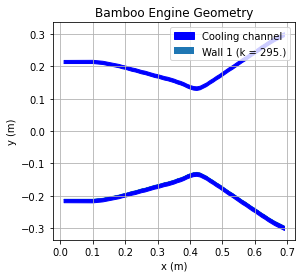

In [7]:
engine.plot()
plt.title("Bamboo Engine Geometry")
plt.show()

In [8]:
# Run simulation
bamboo_data = engine.steady_heating_analysis(num_grid = 1000)

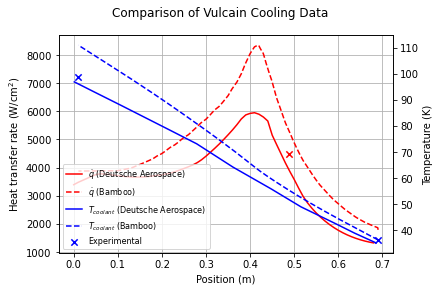

Experimental coolant exit temperature (Deutsche Aerospace) = 98.61 K
Predicted coolant exit temperature (Bamboo) = 110.95 K
Percentage error in coolant exit temperature = 12.51%

Peak heat transfer rate (Deutsche Aerospace) = 5952 W/cm^2
Peak heat transfer rate (Bamboo) = 8352 W/cm2
Percentage error in peak heat transfer rate = 40.32%


In [9]:
# Compare results with data from paper
fig, ax1 = plt.subplots()
fig.suptitle("Comparison of Vulcain Cooling Data")

heat_flux_bamboo = np.array(bamboo_data["dQ_dA"])/(1e4)

# Plot heat transfer rates
ax1.plot(heat_flux_data["x"], 
         heat_flux_data["y"], 
         label= r"$\dot{q}$ (Deutsche Aerospace)", 
         color= "red")

ax1.plot(bamboo_data["x"], 
         heat_flux_bamboo, 
         label= r"$\dot{q}$ (Bamboo)", 
         color="red", 
         linestyle = "--")

ax1.set_xlabel("Position (m)")
ax1.set_ylabel(r"Heat transfer rate (W/cm$^2$)")
ax1.grid()

# Plot coolant temperatures on the same axis
ax2 = ax1.twinx()       
ax2.plot(coolant_temperature_data["x"], 
         coolant_temperature_data["y"], 
         label = r"$T_{coolant}$ (Deutsche Aerospace)", 
         color= "blue")

ax2.plot(bamboo_data["x"], bamboo_data["T_coolant"], 
         label= r"$T_{coolant}$ (Bamboo)", 
         color= "blue", 
         linestyle = "--")

ax2.set_ylabel("Temperature (K)")

# Plot their experimental datapoints
ax1.scatter(experimental_qdot["x"], experimental_qdot["y"], marker = 'x', s = 40, color = "red")
ax2.scatter(bamboo_data["x"][0], experimental_T_in, s = 40, marker = 'x', color = "blue")
ax2.scatter(bamboo_data["x"][-1], experimental_T_out, s = 40, marker = 'x', color = "blue", label = "Experimental")

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc = 'lower left', prop={'size': 8})

plt.show()

print(f'Experimental coolant exit temperature (Deutsche Aerospace) = {experimental_T_out:.2f} K')
print(f'Predicted coolant exit temperature (Bamboo) = {bamboo_data["T_coolant"][-1]:.2f} K')
percent_error = 100*(bamboo_data["T_coolant"][-1] - experimental_T_out)/experimental_T_out
print(f'Percentage error in coolant exit temperature = {abs(percent_error):.2f}%\n')

print(f'Peak heat transfer rate (Deutsche Aerospace) = {max(heat_flux_data["y"]):.0f} W/cm^2')
print(f'Peak heat transfer rate (Bamboo) = {max(heat_flux_bamboo):.0f} W/cm2')
percent_error = 100*(max(heat_flux_bamboo) - max(heat_flux_data["y"]))/max(heat_flux_data["y"])
print(f'Percentage error in peak heat transfer rate = {abs(percent_error):.2f}%')
